## set running directory to project source

In [1]:
import os
import numpy as np
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## 3.1. SceneBuilder

##### Create CombinedRobot instance - you need it to initailize GeometryScene

In [2]:
from pkg.controller.combined_robot import CombinedRobot
from pkg.controller.robot_config import RobotConfig, RobotType
INDY_IP = "192.168.0.63"
PANDA_HOST_IP = "192.168.0.172" ## The host computer is the computer that runs control program
PANDA_ROBOT_IP = "192.168.0.13" ## The robot has it's own IP

combined_robot = CombinedRobot(
    robots_on_scene=[
        RobotConfig(0, RobotType.indy7, ((0,-0.3,0), (0,0,0)),
                    INDY_IP),
        RobotConfig(1, RobotType.panda, ((0,0.3,0), (0,0,0)),
                    "{}/{}".format(PANDA_HOST_IP, PANDA_ROBOT_IP))], 
    connection_list=[False, False])

connection command:
indy0: False
panda1: False


##### initialize ArucoStereo detector

In [3]:
from pkg.detector.aruco.stereo import ArucoStereo
from pkg.detector.aruco.marker_config import get_aruco_map
from pkg.detector.camera.kinect import Kinect
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

# stereo = ArucoStereo(aruco_map=get_aruco_map(), 
#                      camera_list=[Kinect(), RealSense()])

# stereo.initialize()

# time.sleep(1) # Let the camera have some time to get stable
# stereo.calibrate()
# print("Detector initialized")

##### Create SceneBuilder instance

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
scene_builder = SceneBuilder.instance(None)
# scene_builder = SceneBuilder.instance(detector=stereo)

##### reset_reference_coord()
* Set the name of coordinate reference object - here, you need "floor" as reference

In [5]:
# # deprecated: scene_builder.reset_reference_coord(ref_name="floor")

##### detect_items()
* Detect items in the field of view. Here, we detect robot positions and update it to the combined robot

In [6]:
# xyz_rpy_robots = scene_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
# combined_robot.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)

##### create_gscene()
* Create a GeometryScene instance

In [7]:
gscene = scene_builder.create_gscene(combined_robot)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


##### detect_and_register()
* Detect items in the field of view and register them to the GeometryScene
* They will appear in the RVIZ

In [8]:
# gtem_dict = scene_builder.detect_and_register(level_mask=[DetectionLevel.ENVIRONMENT])
# gtem_dict = scene_builder.detect_and_register(level_mask=[DetectionLevel.MOVABLE])

## FT sensor

In [9]:
import sys
RNB_TRACK_DIR = os.path.join(os.environ['RNB_TRACK_DIR'])
sys.path.append(RNB_TRACK_DIR)
from robotous_ft import *
rft = RobotousFT()

==== Robotus FT sensor connected ====
[Model]    RFT44-6A02-D         
[Firmware] RFT40-01-2-04        


In [10]:
# gscene.show_pose(combined_robot.home_pose)
Tbe = gscene.get_tf("indy0_tcp", combined_robot.home_pose)
for _ in range(100):
    ft = rft.read_once()
    gscene.show_wrench("ft", ft*10, Tbe)
    time.sleep(0.05)

Please create a subscriber to the marker


## Vive
#### Prepare VR
1. Start vrmonitor
2. Turn on trackers - push until led blinks or change to green - Trackers will be displayed green on the SteamVR
  - Turn on the reference tracker first

In [11]:
from pkg.utils.shared_function import clear_channels_on
from pkg.detector.vive.shared_vive import SharedTrackers, SERVER_ID

In [12]:
# clear_channels_on(SERVER_ID)
track = SharedTrackers()
track.init_vive()

#### Set reference

In [14]:
from pkg.geometry.geotype import *

In [16]:
gscene.create_safe(GEOTYPE.BOX, "vive_ref", dims = (0.01,0.01,0.01), center=(0,0,0), link_name="base_link")

In [17]:
vive_ref = gscene.NAME_DICT["vive_ref"]
tf_base_ref = vive_ref.get_tf(combined_robot.home_pose)
track.set_reference(ref_name="tracker_1", tf_base_ref=tf_base_ref)

#### show tracker coordinates

In [41]:
time_list = []
ft_list = []
pose_list = []
for _ in range(600):
    try:
        time_list.append(time.time())
        pose_dict = track.get_all_pose()
        ft = rft.read_once()
        pose_list.append(pose_dict["tracker_2"])
        ft_list.append(ft)
#         for tname, T in pose_dict.items():
#             gscene.add_highlight_axis("hl", tname, T=np.array(T))
#         time.sleep(0.1)
    except Exception as e:
        print(e)

In [43]:
from pkg.utils.utils import *

In [44]:
# save_pickle("data/track_dat.pkl", 
#             {"time_list": time_list, 
#              "ft_list": ft_list, 
#              "pose_list": pose_list})

In [45]:
track_dat = load_pickle("data/track_dat.pkl")
time_list = track_dat["time_list"]
ft_list = track_dat["ft_list"]
pose_list = track_dat["pose_list"]

In [ ]:
time_list

In [39]:
ft_list[0]

array([ -3.1   ,   7.36  , -25.08  ,  -0.0305,   0.27  ,   0.049 ])

In [38]:
ft_list[-1]

array([-5.060e+00,  1.132e+01, -3.582e+01,  1.750e-02,  6.840e-01,
        1.315e-01])

In [53]:
np.round(pose_list[-1], 2)

array([[ 0.26, -0.96,  0.01,  0.25],
       [ 0.96,  0.26, -0.  , -0.41],
       [-0.  ,  0.01,  1.  , -0.02],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [145]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

sample rate: 62.6 Hz


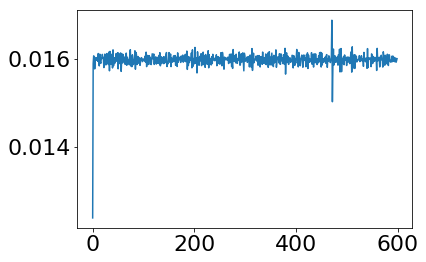

In [146]:
dt_list = np.subtract(time_list[1:], time_list[:-1])
plt.plot(dt_list)
print("sample rate: {:.3} Hz".format(1.0/np.mean(dt_list)))

In [54]:
gscene.clear_highlight()

In [63]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as mplot3d

In [161]:
xlist, ylist, zlist =[], [], []
ulist, vlist, wlist =[], [], []
for ft, pose in zip(ft_list, pose_list):
    xlist.append(np.array(pose)[0,3])
    ylist.append(np.array(pose)[1,3])
    zlist.append(np.array(pose)[2,3])
    ulist.append(ft[0])
    vlist.append(ft[1])
    wlist.append(ft[2])

tlist = np.subtract(time_list, time_list[0])
ft_scale = 0.001
idx_zero = np.argmin(zlist) # when tool is up
ulist = np.subtract(ulist, ulist[idx_zero])*ft_scale # subtract bias
vlist = np.subtract(vlist, vlist[idx_zero])*ft_scale # subtract bias
wlist = np.subtract(wlist, wlist[idx_zero])*ft_scale # subtract bias

In [108]:
gscene.highlight_geometry("hl", "vive_ref")

In [170]:
plt.rcParams.update({'font.size': 14})

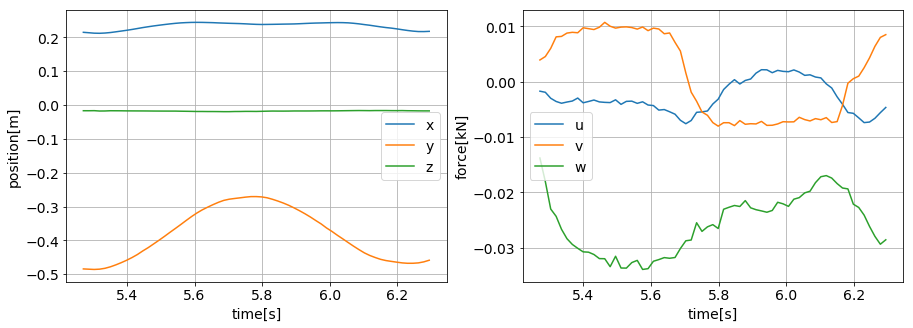

In [171]:
idx_begin = 330
idx_center = 360
idx_end = 395
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(tlist[idx_begin:idx_end], xlist[idx_begin:idx_end])
plt.plot(tlist[idx_begin:idx_end], ylist[idx_begin:idx_end])
plt.plot(tlist[idx_begin:idx_end], zlist[idx_begin:idx_end])
plt.legend("xyz")
plt.ylabel("position[m]")
plt.xlabel("time[s]")
plt.grid()
plt.subplot(1,2,2)
plt.plot(tlist[idx_begin:idx_end], ulist[idx_begin:idx_end])
plt.plot(tlist[idx_begin:idx_end], vlist[idx_begin:idx_end])
plt.plot(tlist[idx_begin:idx_end], wlist[idx_begin:idx_end])
plt.legend("uvw")
plt.ylabel("force[kN]")
plt.xlabel("time[s]")
plt.grid()

In [172]:

plt.rcParams.update({'font.size': 12})

Text(0.5,0,'z (m)')

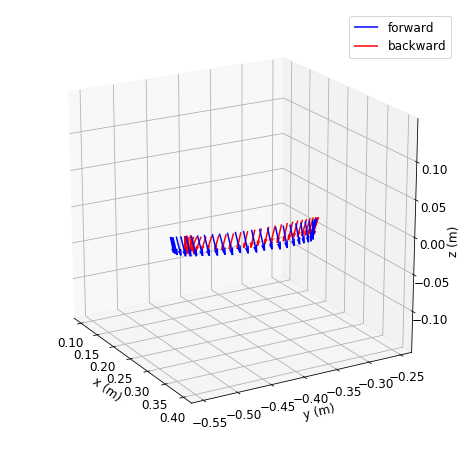

In [174]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.quiver(xlist[idx_begin:idx_center], 
          ylist[idx_begin:idx_center], 
          zlist[idx_begin:idx_center], 
          ulist[idx_begin:idx_center], 
          vlist[idx_begin:idx_center], 
          wlist[idx_begin:idx_center], color=(0,0,1))
ax.quiver(xlist[idx_center:idx_end], 
          ylist[idx_center:idx_end], 
          zlist[idx_center:idx_end], 
          ulist[idx_center:idx_end], 
          vlist[idx_center:idx_end], 
          wlist[idx_center:idx_end], color=(1,0,0))
ax.legend(["forward", "backward"])
ax.plot3D([0.1],[-0.55],[-0.15])
ax.plot3D([0.4],[-0.25],[0.15])
ax.axis("equal")
ax.view_init(20,-30)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_zlabel("z (m)")

## FFT - y position

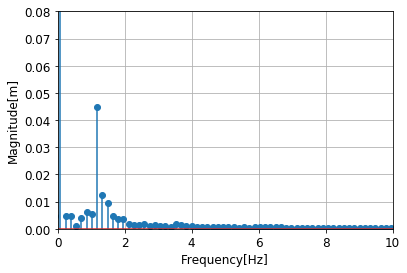

In [295]:
fs = 1.0/np.mean(dt_list)
t = tlist[idx_start:]
signal = ylist[idx_start:]

fft = np.fft.fft(signal) / len(signal)  
 
fft_magnitude = abs(fft)

length = len(signal)
f = np.linspace(-(fs / 2), fs / 2, length)
 
plt.stem(f, np.fft.fftshift(fft_magnitude)) 
plt.ylim(0,0.08)
plt.xlim(0,10)
plt.grid()
plt.ylabel("Magnitude[m]")
plt.xlabel("Frequency[Hz]")
 
plt.show()

## FFT - y force

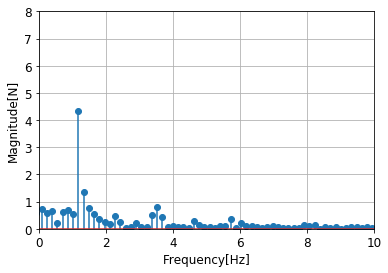

In [296]:
fs = 1.0/np.mean(dt_list)
t = tlist[idx_start:]
signal = np.multiply(vlist[idx_start:], 1.0/ft_scale)

fft = np.fft.fft(signal) / len(signal)  
 
fft_magnitude = abs(fft)

length = len(signal)
f = np.linspace(-(fs / 2), fs / 2, length)
 
plt.stem(f, np.fft.fftshift(fft_magnitude)) 
plt.ylim(0,8)
plt.xlim(0,10)
plt.grid()
plt.ylabel("Magnitude[N]")
plt.xlabel("Frequency[Hz]")
 
plt.show()

### Velocity-Force plot

In [306]:
fs = 1.0/np.mean(dt_list[idx_start:])
t_list = tlist[idx_start:]
dxlist = np.subtract(xlist[idx_start:], xlist[idx_start-1:-1])*fs
dylist = np.subtract(ylist[idx_start:], ylist[idx_start-1:-1])*fs
dzlist = np.subtract(zlist[idx_start:], zlist[idx_start-1:-1])*fs
u_list = ulist[idx_start:]
v_list = vlist[idx_start:]
w_list = wlist[idx_start:]

In [307]:
from pkg.utils.rotation_utils import *

In [322]:
rotvec_list = []
ang_list = []
for i in range(len(dxlist)):
    vel = [dxlist[i], dylist[i], dzlist[i]]
    # vel_nm = np.divide(vel, np.linalg.norm(vel))
    force = [u_list[i], v_list[i], w_list[i]]
    # force_nm = np.divide(force, np.linalg.norm(force))
    rotvec = calc_rotvec_vecs(vel, force)

    ang = np.linalg.norm(rotvec)
    rotvec_list.append(rotvec)
    ang_list.append(np.sign(rotvec[0]) * ang)

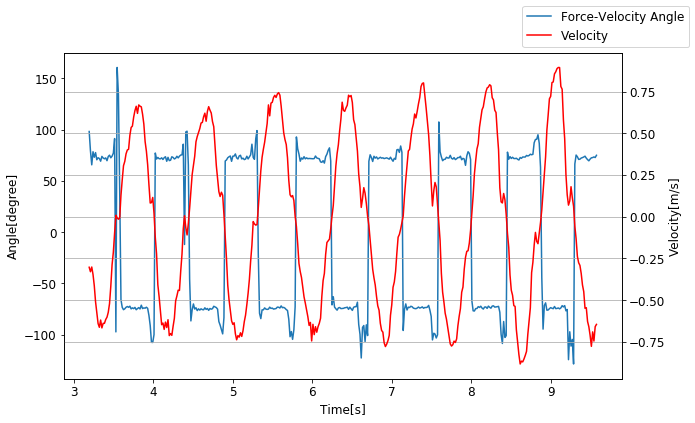

In [344]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(t_list, np.rad2deg(ang_list))
ax.set_xlabel("Time[s]")
ax.set_ylabel("Angle[degree]")

ax2 = ax.twinx()
ax2.plot(t_list, dylist, '-r')
ax2.grid()
ax2.set_ylabel("Velocity[m/s]")

fig.legend(["Force-Velocity Angle", "Velocity"])

### Drawing pose realtime

In [12]:
for _ in range(50):
    try:
        pose_dict = track.get_all_pose()
        for tname, T in pose_dict.items():
            gscene.add_highlight_axis("hl", tname, T=np.array(T))
        time.sleep(0.1)
    except Exception as e:
        print(e)

#### Draw error arrow

In [13]:
from pkg.utils.rotation_utils import *
from pkg.utils.plot_utils import ArrowStream, draw_background_multi

In [14]:
ref_pos = track.get_pose(tname="tracker_2")
xy_ref = ref_pos[:2, 3]
theta_ref = Rot2axis(ref_pos[:3, :3], 3)
gscene.add_highlight_axis("hl", "tracker_2_ref", T=ref_pos)
def arrow_update_xy():
    try:
        cur_pos = track.get_pose(tname="tracker_2")
        gscene.add_highlight_axis("hl", "tracker_2", T=cur_pos)
        arrow_update_xy.cur_pos = cur_pos
    except:
        cur_pos = arrow_update_xy.cur_pos
    xy_cur = cur_pos[:2, 3]
    theta_cur = Rot2axis(cur_pos[:3, :3], 3)
    
    xy_diff = np.subtract(xy_ref, xy_cur)
    theta_diff = np.subtract(theta_ref, theta_cur)
    
    length = np.linalg.norm(xy_diff)
    
    return length, np.arctan2(xy_diff[1], xy_diff[0]), (0,0,1)

arrow_update_xy()

def arrow_update_theta():
    cur_pos = arrow_update_xy.cur_pos
    xy_cur = cur_pos[:2, 3]
    theta_cur = Rot2axis(cur_pos[:3, :3], 3)
    
    xy_diff = np.subtract(xy_ref, xy_cur)
    theta_diff = np.subtract(theta_ref, theta_cur)
    theta_diff = (theta_diff + np.pi) % (np.pi*2)-np.pi
    
    if theta_diff >= 0:
        angle=0
    else:
        angle=np.pi
    
    return np.abs(theta_diff)/np.pi, angle, (1,0,0)

In [25]:
astream_xy = ArrowStream(arrow_update_xy, sname="xy")
astream_theta = ArrowStream(arrow_update_theta, im_size=(200, 500), sname="theta")

In [26]:
draw_background_multi([astream_xy, astream_theta])

In [23]:
astream_xy.stop_now()
astream_theta.stop_now()